In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print(hub.__version__)
print("GPU", "Available" if tf.config.list_physical_devices("GPU") else "NO GPU")

2.14.0
0.15.0
GPU Available


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

# Preparing the data

In [ ]:
cats_dir = 'drive/MyDrive/Colab Notebooks/archive/Cat'
dogs_dir = 'drive/MyDrive/Colab Notebooks/archive/Dog'
cat_files = [os.path.join(cats_dir, filename) for filename in os.listdir(cats_dir)]
dog_files = [os.path.join(dogs_dir, filename) for filename in os.listdir(dogs_dir)]

In [ ]:
len(cat_files), len(dog_files)

(12405, 12364)

In [ ]:
cat_labels = [0] * len(cat_files)
dog_labels = [1] * len(dog_files)

cat_labels = np.array(cat_labels)
dog_labels = np.array(dog_labels)

In [ ]:
X = cat_files + dog_files
y = np.concatenate((cat_labels, dog_labels))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
IMG_SIZE = 224

#Function for image preprocessing
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes image file path and turns it into Tensor.
  """
  #Read in an image file
  image = tf.io.read_file(image_path)
  #Turn the jpeg image into numerical Tensor with 3 colour channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  #Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  #Resize the image to our desired value (224,224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

# Making Batches

In [ ]:
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [ ]:
from pickle import FALSE
BATCH_SIZE = 32

def create_data_batches(X, y = None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  # If the data is a test dataset, we most likely won't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


#Building model

In [ ]:
#Setup input
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channels

#Setup model URL from tensorflow hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=1, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=1,
                          activation="sigmoid") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

#Callbacks

In [ ]:
%load_ext tensorboard

In [ ]:
import datetime

def create_tensorboard_callback():
  logdir = os.path.join("drive/MyDrive/Colab Notebooks/archive2/logs",
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

# Model Training

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=100,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [ ]:
model = train_model()

## Saving Model

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Colab Notebooks/archive2/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

## Loading Model

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
#save_model(model, suffix="catdog_class")

In [ ]:
model = load_model("/content/drive/MyDrive/Colab Notebooks/archive2/models/20231103-16521699030376-catdog_class.h5")

Loading saved model from: /content/drive/MyDrive/Colab Notebooks/archive2/models/20231103-16521699030376-catdog_class.h5


# Prediction on validation data

In [ ]:
predictions = model.predict(val_data, verbose=1)
predictions

155/155 [==============================] - 472s 3s/step


array([[1.9093165e-04],
       [9.7288743e-05],
       [1.3472090e-06],
       ...,
       [1.0416217e-04],
       [9.9364412e-01],
       [6.2801682e-06]], dtype=float32)

In [ ]:
def unbatchify(data):
  images = []
  labels = []

  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(label)
  return images, labels

val_images, val_labels = unbatchify(val_data)

In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  # Interpret the prediction
  if prediction_probabilities <= 0.5:
      pred = np.array("cat")
  else:
      pred = np.array("dog")
  return pred

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  if pred_prob <= 0.5:
      pred = np.array("Cat")
      pred_prob = 1-pred_prob
  else:
      pred = np.array("Dog")

  if true_label == 0:
    true = np.array("Cat")
  else:
    true = np.array("Dog")

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred == true:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("Prediction: {} {:.2f}% \n True Label: {}".format(pred, *pred_prob*100, true), color=color)

In [ ]:
import random

def plot_predictions(prediction_probabilities, labels, images, rows, columns):
    fig, axes = plt.subplots(rows, columns, figsize=(12, 12))  # Create a 5x4 grid

    for i in range(rows):
        for j in range(columns):
            n = random.randint(0, len(images) - 1)  # Get a random index
            pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

            if pred_prob <= 0.5:
                pred = "Cat"
                pred_prob = 1 - pred_prob
            else:
                pred = "Dog"

            true = "Cat" if true_label == 0 else "Dog"

            # Plot image & remove ticks
            axes[i, j].imshow(image)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            # Change the color of the title depending on if the prediction is right or wrong
            if pred == true:
                color = "green"
            else:
                color = "red"

            # Change plot title to be predicted, probability of prediction, and true label
            axes[i, j].set_title("Prediction: {} {:.2f}%\nTrue Label: {}".format(pred, *pred_prob*100, true), color=color)

    plt.tight_layout()
    plt.show()

In [ ]:
# Call the function to plot 20 random predictions
rows = 2 #@param {type:"slider", min:2, max:5, step:1}
cols = 2 #@param {type:"slider", min:2, max:5, step:1}
plot_predictions(prediction_probabilities=predictions, labels=val_labels, images=val_images, rows=rows, columns=cols)

# Prediction on test data (unlabeled dataset)

In [ ]:
# Load test image filenames
test_path = "drive/MyDrive/Colab Notebooks/archive2/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

In [ ]:
len(test_filenames)

140

In [ ]:
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [ ]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
# Predictions on test data batch using the loaded full model
test_predictions = model.predict(test_data,verbose=1)

5/5 [==============================] - 20s 4s/step


In [ ]:
test_predictions

In [ ]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("drive/MyDrive/Colab Notebooks/Cat_Dog_Class_preds_array.csv", test_predictions, delimiter=",")

In [ ]:
test_pred_labels = [get_pred_label(test_predictions[i]) for i in range(len(test_predictions))]
test_pred_labels

In [ ]:
test_images = []
# Loop through unbatched data
for image in test_data.unbatch().as_numpy_iterator():
  test_images.append(image)

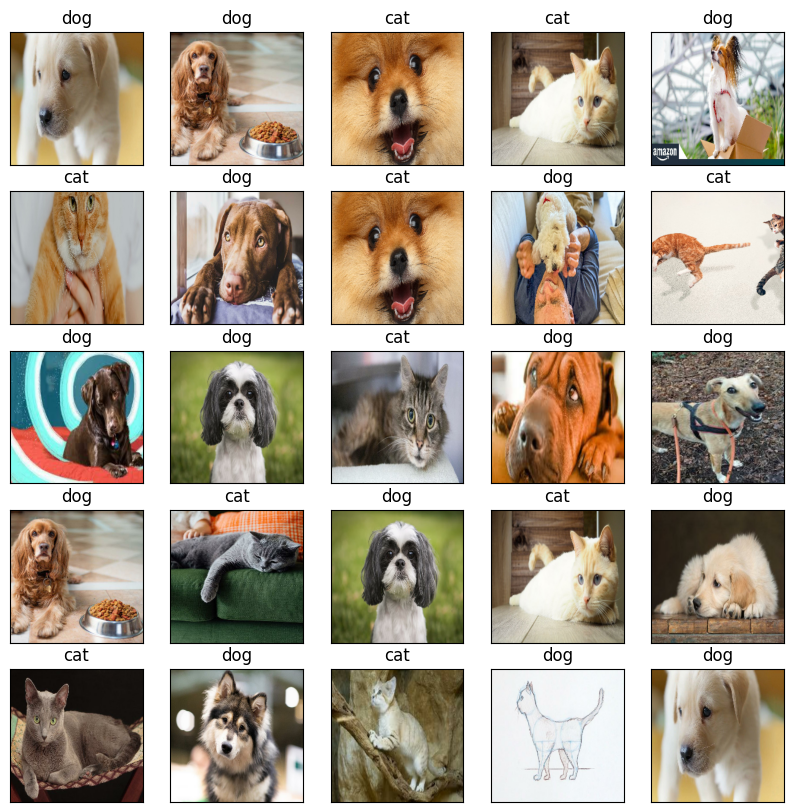

In [ ]:
# Check 25 random images with their respective prediction
plt.figure(figsize=(10, 10))
for i in range(25):
  n = random.randint(0, len(test_images) - 1)
  image = test_images[n]
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(test_pred_labels[n])
  plt.imshow(image)